## 네이버 영화 리뷰 감정 분석 문제에 SentencePiece 적용해보기

- 네이버 영화 리뷰 감정 분석 문제에서 Tokenizer를 SentencePiece로 교체하면 더 성능이 좋아질까?
- KoNLPy의 Mecab, kkma, Okt 등과 비교하기

### 1. 라이브러리 설치 및 데이터 다운로드

In [1]:
!pip -q install sentencepiece konlpy tqdm scikit-learn

In [2]:
import os, re, csv, urllib.request
from pathlib import Path
from typing import List, Tuple

ROOT = Path('.')
DATA_DIR = ROOT/'data_nsmc'
DATA_DIR.mkdir(exist_ok=True, parents=True)

def download(url, dest):
    if not dest.exists():
        urllib.request.urlretrieve(url, dest)
        print(f"Downloaded: {dest.name}")
    else:
        print(f"Exists: {dest.name}")

base = "https://raw.githubusercontent.com/e9t/nsmc/master"
download(f"{base}/ratings_train.txt", DATA_DIR/'ratings_train.txt')
download(f"{base}/ratings_test.txt",  DATA_DIR/'ratings_test.txt')

Exists: ratings_train.txt
Exists: ratings_test.txt


### 2. 데이터 불러오기 및 정규화

In [3]:
def load_nsmc(path: Path):
    texts, labels = [], []                                       # 리뷰 문장과 라벨을 저장할 리스트 준비
    with open(path, encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for row in reader:
            t, y = row['document'], row['label']                 # document = 리뷰 문장, label = 감정 레이블
            if t and y in ('0','1'):                             # 감정 레이블이 존재할 때만
                texts.append(t)                                  # 리뷰 문장을 추가합니다
                labels.append(int(y))
    return texts, labels

train_texts, train_labels = load_nsmc(DATA_DIR/'ratings_train.txt')                 # ~ texts = 영화 리뷰 문장 리스트
test_texts,  test_labels  = load_nsmc(DATA_DIR/'ratings_test.txt')                  # ~ labels = 긍정 부정 정답 라벨 리스트

In [4]:
train_texts[:5]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']

In [5]:
train_labels[:5]

[0, 1, 0, 0, 1]

- 텍스트 정규화 과정

In [6]:
# 정규 표현식 패턴 정의
# 여기에 속하지 않는 문자들을 찾아낸다
NORMALIZE_RE = re.compile(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ\s\.\,\!\?\:\;\'\"\(\)\[\]\-]+")
                          
def clean_text(s: str) -> str:                
    s = (s or "").strip()                     # 문자열이 None이면 ""로 처리, 앞뒤 공백 제거    
    s = NORMALIZE_RE.sub(" ", s)              # 허용되지 않은 문자 → 공백으로 치환
    s = re.sub(r"\s+", " ", s)                # 연속된 공백(2칸 이상) → 한 칸으로 축소
    return s

train_texts = [clean_text(t) for t in train_texts]
test_texts  = [clean_text(t) for t in test_texts]
len(train_texts), len(test_texts)

(149995, 49997)

### 3. SentencePiece 학습 및 적용하기 + sp_tokenize() 구현

In [7]:
import sentencepiece as spm

# SentencePiece 모델 파일과 임시 코퍼스 파일 저장용 디렉토리
SP_DIR = ROOT/'sp_models'
SP_DIR.mkdir(exist_ok=True)

In [8]:
# SentencePiece 학습 함수

def train_sentencepiece(corpus: list,                                   # 학습할 NSMC 리뷰 텍스트 리스트
                        model_prefix: str,                              
                        vocab_size: int = 8000,                         # 어휘집 크기 = 기본 8000
                        model_type: str = "unigram",                    # 토큰화 방식 = unigram이 한국어에 가장 잘 맞음
                        character_coverage: float = 0.9995):            # 0.9998 만큼 커버한다 = 데이터 안의 거의 모든 문자를 포함한다

    # 학습 데이터 준비
    tmp_corpus = SP_DIR / f"{model_prefix}.txt"
    with open(tmp_corpus, "w", encoding="utf-8") as f:
        for line in corpus:
            f.write(line+"\n")
    
    # SentencePiece 학습 실행
    spm.SentencePieceTrainer.train(
        input=str(tmp_corpus),
        model_prefix=str(SP_DIR/model_prefix),
        vocab_size=vocab_size,
        model_type=model_type,
        character_coverage=character_coverage,
        pad_id=0, unk_id=1, bos_id=2, eos_id=3                           # 특수 토큰 ID 지정하기
    )
    return str(SP_DIR/f"{model_prefix}.model")

In [9]:
# SentencePiece 모델 불러오기
def load_sp(model_path: str):
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)
    return sp                            # .model 파일을 통해 토크나이저 객체 생성

# 토큰화 함수
def sp_tokenize(text: str, sp):
    return sp.encode(text, out_type=int)

# Unigram-8k
sp_model_path = train_sentencepiece(train_texts, model_prefix="sp_uni8k", vocab_size=8000, model_type="unigram")
sp = load_sp(sp_model_path)
sp.vocab_size()

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_models/sp_uni8k.txt
  input_format: 
  model_prefix: sp_models/sp_uni8k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential

8000

In [10]:
# ID 시퀀스 변환 및 복원 결과 확인

text = "사이몬페그의 익살스런 연기가 돋보였던 영화! 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다!"
ids = sp_tokenize(text, sp)
print("토큰 ID:", ids)
print("복원:", sp.decode(ids))

토큰 ID: [2389, 2381, 2247, 165, 11, 4, 1436, 317, 2373, 499, 2665, 1789, 8, 26, 4, 5704, 46, 6317, 2509, 1228, 2863, 2392, 6286, 4, 115, 677, 10, 2225, 4, 4804, 6938, 26]
복원: 사이몬페그의 익살스런 연기가 돋보였던 영화! 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다!


### 4. SentencePiece와 Konlpy - Mecab 비교하기 전 환경 셋팅

- 두 가지 토크나이즈 방식을 같은 분류 모델로 비교
    - SentencePiece : ```experiment_sp()``` 함수에서 SP 모델 학습 → 토큰화 → 학습/평가
    - MeCab(형태소) : 직접 ```morphs()```로 토큰화 → 보카빌드 → 학습/평가
- 모델 : BiLSTMMaxPoolClassifier (임베딩 → 양방향 LSTM → 맥스풀 → 선형)
- 데이터 : 이미 준비된 train_texts/test_texts와 레이블에서 train/valid/test로 분할
- 평가: Accuracy/F1 출력 · 반환

In [19]:
# Mecab 토크나이저 정의

from konlpy.tag import Mecab
MECAB = Mecab()

def tokenize_mecab(text: str):       # 입력 문장을 형태소 단위 리스트로 자르는 함수
    return MECAB.morphs(text)

- 라이브러리 불러오기

In [18]:
import torch, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

Device: cuda


In [20]:
# 데이터 분할 (train_texts/labels = 90/10)
# 테스트는 그대로 사용합니다

X_tr, X_va, y_tr, y_va = train_test_split(
    train_texts, train_labels, test_size=0.1,
    random_state=42, stratify=train_labels
)
X_te, y_te = test_texts, test_labels

- 최대 시퀀스 길이 128 토큰으로 자르고/패딩
- 배치 256, 학습 6 epoch, AdamW 학습률 0.002
- 임베딩 차원 200, LSTM hidden 256(양방향이라 최종 512), 드롭아웃 0.2, num_workers 2

In [37]:
MAX_LEN   = 128
BATCH     = 256
EPOCHS    = 6
LR        = 2e-3
EMBED_DIM = 200
HIDDEN    = 256
DROPOUT   = 0.2
NUM_WORKERS = 2

In [38]:
# 형태소 토큰용 Vocab 사전 빌드 + 인코딩/패딩

def build_vocab(tokenized_corpus, min_freq=2, specials=None):
    specials = specials or ["<PAD>", "<UNK>"]
    cnt = Counter()
    for toks in tokenized_corpus:
        cnt.update(toks)
    itos = list(specials)
    for w, c in cnt.most_common():
        if c >= min_freq:
            itos.append(w)
    return {w:i for i,w in enumerate(itos)}

In [39]:
# 형태소 단위 토큰을 정수 ID 시퀀스로 바꿉니다

def encode_tokens(tokens, stoi, max_len=128):
    unk = stoi.get("<UNK>", 1)                                # '<UNK>' 토큰의 ID. 없으면 1번으로 기본 설정
    ids = [stoi.get(t, unk) for t in tokens]

    # 주어진 tokens 리스트(예: ["영화", "재밌다"])에서
    # 각 토큰을 stoi 딕셔너리에서 찾아서 숫자로 바꿉니다
    # 만약 없는 토큰이면 unk(=1)으로 대체
    
    if len(ids) < max_len:
        ids += [0]*(max_len-len(ids))
        # max_len보다 짧으면 PAD(0)으로 뒤를 채워줍니다
        
    return ids[:max_len]
    # max_len보다 길면 잘라냅니다 (문장의 길이를 일정하게 맞추기)

In [40]:
# 패딩, 잘라내기 함수
# SentencePiece는 자체적으로 ID를 주기 때문에 pad_ids만 필요합니다
# 하지만 Mecab은 토큰을 뽑기만 하니까 encode_tokens (위의 함수) 함수가 필요합니다.

def pad_ids(ids, max_len=128):
    if len(ids) < max_len:
        ids += [0]*(max_len-len(ids))
    return ids[:max_len]

- 영화 리뷰 하나를 (숫자 시퀀스 레이블)로 변환하는 함수 구성
- Pytorch의 DataLodaer가 이 클래스를 감싸면 자동으로 batch 단위로 (X_batch, y_batch)를 뽑아줍니다.
- SentencePiece와 형태소 분석기를 같은 코드 구조 안에서 비교할 수 있습니다.

In [41]:
class NSMCDataset(Dataset):
    def __init__(self, texts, labels, kind="sp", sp=None, tok_func=None, stoi=None, max_len=128):
        self.texts, self.labels = texts, labels
        self.kind, self.sp, self.tok_func, self.stoi = kind, sp, tok_func, stoi
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        t, y = self.texts[i], self.labels[i]
        if self.kind == "sp":
            ids = sp_tokenize(t, self.sp)
            x = torch.tensor(pad_ids(ids, self.max_len), dtype=torch.long)
        else:
            toks = self.tok_func(t)
            x = torch.tensor(encode_tokens(toks, self.stoi, self.max_len), dtype=torch.long)
        return x, torch.tensor(y, dtype=torch.float32)

#### ***감정 분석을 수행할 모델 BiLSTMMaxPoolClassifier***
- LSTM 순환 신경망 → 입력 : (배치 크기, 시퀀스 길이, 임베딩 차원) → 출력 (B, L, 2H)
- ```bidrectional = True```라서 정방향 + 역방향 총 2개의 LSTM을 사용합니다.

- BiLSTM : 앞뒤 문맥을 모두 반영합니다.
- MaxPooling : 문장 전체에서 가장 중요한 특징만 추출합니다.
- FC Layer : 긍정/부정 확률 출력합니다.

In [42]:
class BiLSTMMaxPoolClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, hidden_dim=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, 1)
    def forward(self, x):
        emb = self.embedding(x)          # (B, L, E)
        out, _ = self.lstm(emb)          # (B, L, 2H) 양방향
        pooled, _ = torch.max(out, dim=1)# (B, 2H) 시간축 맥스풀
        return self.fc(self.dropout(pooled)).squeeze(1)  # (B,)

In [43]:
# 1 epoch 당 모델 학습 함수

def train_epoch(model, loader, opt, crit):
    model.train(); losses=[]
    for X,y in tqdm(loader, leave=False):
        X,y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        logits = model(X)
        loss = crit(logits, y)
        loss.backward(); opt.step()
        losses.append(loss.item())
    return float(np.mean(losses))

In [44]:
# 평가 함수

@torch.no_grad()                                       # 평가 단계 - 순전파만 실행
def evaluate(model, loader, crit):
    model.eval(); losses=[]; all_y=[]; all_p=[]
    for X,y in loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X); loss = crit(logits, y)
        probs = torch.sigmoid(logits)                  # BCEWithLogitsLoss와 짝
        preds = (probs>0.5).float()                    # 임계값 0.5 - 0.5 이상이면 긍정 / 이하면 부정
        losses.append(loss.item())
        all_y += y.cpu().numpy().tolist()
        all_p += preds.cpu().numpy().tolist()
    return float(np.mean(losses)), accuracy_score(all_y, all_p), f1_score(all_y, all_p)

In [45]:
# 학습, 검증, 체크포인트 복원

def run_training(train_ds, valid_ds, vocab_size):
    model = BiLSTMMaxPoolClassifier(vocab_size, EMBED_DIM, HIDDEN, DROPOUT).to(DEVICE)
    
    NUM_WORKERS = 0
    tr = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
    va = DataLoader(valid_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

    crit = nn.BCEWithLogitsLoss()
    opt  = torch.optim.AdamW(model.parameters(), lr=LR)
    best = {"acc":0.0,"state":None,"ep":0}
    for ep in range(1, EPOCHS+1):
        tl = train_epoch(model, tr, opt, crit)
        vl, va_acc, va_f1 = evaluate(model, va, crit)
        if va_acc>best["acc"]:
            best = {"acc":va_acc, "state":{k:v.detach().cpu() for k,v in model.state_dict().items()}, "ep":ep}
        print(f"[Ep {ep:02d}] tr_loss={tl:.4f}  va_loss={vl:.4f}  va_acc={va_acc:.4f}  va_f1={va_f1:.4f}")
    if best["state"] is not None:
        model.load_state_dict(best["state"])
    return model

In [46]:
def experiment_sp(model_type="unigram", vocab_size=8000, tag=""):
    sp_path = train_sentencepiece(
        X_tr, model_prefix=f"sp_{model_type}_{vocab_size}{('_'+tag) if tag else ''}",
        vocab_size=vocab_size, model_type=model_type
    )
    sp = load_sp(sp_path)
    vsize = sp.vocab_size()

    tr_ds = NSMCDataset(X_tr, y_tr, kind="sp", sp=sp, max_len=MAX_LEN)
    va_ds = NSMCDataset(X_va, y_va, kind="sp", sp=sp, max_len=MAX_LEN)
    te_ds = NSMCDataset(X_te, y_te, kind="sp", sp=sp, max_len=MAX_LEN)

    model = run_training(tr_ds, va_ds, vocab_size=vsize)

    te = DataLoader(te_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

    crit = nn.BCEWithLogitsLoss()
    te_loss, te_acc, te_f1 = evaluate(model, te, crit)
    print(f"[SP {model_type}-{vocab_size}] TEST: loss={te_loss:.4f} acc={te_acc:.4f} f1={te_f1:.4f}")
    return {"family":"SP","type":model_type,"vocab":vsize,"acc":te_acc,"f1":te_f1}

### 5. SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [47]:
# 실행 - unigram
res_sp_uni8k  = experiment_sp("unigram", 8000)

  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 01] tr_loss=0.4139  va_loss=0.3372  va_acc=0.8531  va_f1=0.8510


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 02] tr_loss=0.2916  va_loss=0.3202  va_acc=0.8634  va_f1=0.8633


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 03] tr_loss=0.2378  va_loss=0.3265  va_acc=0.8611  va_f1=0.8580


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 04] tr_loss=0.1814  va_loss=0.3644  va_acc=0.8571  va_f1=0.8602


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 05] tr_loss=0.1298  va_loss=0.4103  va_acc=0.8573  va_f1=0.8532


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 06] tr_loss=0.0944  va_loss=0.4800  va_acc=0.8493  va_f1=0.8518
[SP unigram-8000] TEST: loss=0.3236 acc=0.8595 f1=0.8599


In [48]:
# 실행 - bpe
res_sp_bpe16k = experiment_sp("bpe", 16000)

  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 01] tr_loss=0.4273  va_loss=0.3404  va_acc=0.8511  va_f1=0.8485


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 02] tr_loss=0.2854  va_loss=0.3223  va_acc=0.8612  va_f1=0.8618


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 03] tr_loss=0.2204  va_loss=0.3490  va_acc=0.8553  va_f1=0.8581


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 04] tr_loss=0.1640  va_loss=0.3844  va_acc=0.8569  va_f1=0.8537


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 05] tr_loss=0.1027  va_loss=0.4740  va_acc=0.8513  va_f1=0.8527


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 06] tr_loss=0.0660  va_loss=0.5640  va_acc=0.8521  va_f1=0.8526
[SP bpe-16000] TEST: loss=0.3273 acc=0.8586 f1=0.8592


In [57]:
# 실행 - unigram16
res_sp_uni16k = experiment_sp("unigram", 16000)

  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 01] tr_loss=0.4278  va_loss=0.3408  va_acc=0.8536  va_f1=0.8525


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 02] tr_loss=0.2908  va_loss=0.3233  va_acc=0.8642  va_f1=0.8647


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 03] tr_loss=0.2255  va_loss=0.3369  va_acc=0.8579  va_f1=0.8531


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 04] tr_loss=0.1693  va_loss=0.3713  va_acc=0.8569  va_f1=0.8585


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 05] tr_loss=0.1100  va_loss=0.4653  va_acc=0.8538  va_f1=0.8524


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 06] tr_loss=0.0768  va_loss=0.5146  va_acc=0.8511  va_f1=0.8506
[SP unigram-16000] TEST: loss=0.3284 acc=0.8586 f1=0.8596


In [58]:
# 실행 - bpe8
res_sp_bpe8k = experiment_sp("bpe", 8000)

  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 01] tr_loss=0.4165  va_loss=0.3369  va_acc=0.8498  va_f1=0.8468


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 02] tr_loss=0.2943  va_loss=0.3203  va_acc=0.8591  va_f1=0.8597


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 03] tr_loss=0.2414  va_loss=0.3333  va_acc=0.8585  va_f1=0.8553


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 04] tr_loss=0.1885  va_loss=0.3648  va_acc=0.8561  va_f1=0.8602


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 05] tr_loss=0.1304  va_loss=0.4121  va_acc=0.8568  va_f1=0.8580


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 06] tr_loss=0.0885  va_loss=0.4854  va_acc=0.8487  va_f1=0.8461
[SP bpe-8000] TEST: loss=0.3229 acc=0.8582 f1=0.8591


### 6. MeCab 성능 확인

- MeCab 형태소 분석기로 텍스트 전처리(토큰화) - 훈련 / 검증 / 테스트

In [49]:
# 토큰화
Xtr_tok = [tokenize_mecab(t) for t in tqdm(X_tr, desc="MeCab tokenize train")]
Xva_tok = [tokenize_mecab(t) for t in tqdm(X_va, desc="MeCab tokenize valid")]
Xte_tok = [tokenize_mecab(t) for t in tqdm(X_te, desc="MeCab tokenize test")]

MeCab tokenize train:   0%|          | 0/134995 [00:00<?, ?it/s]

MeCab tokenize valid:   0%|          | 0/15000 [00:00<?, ?it/s]

MeCab tokenize test:   0%|          | 0/49997 [00:00<?, ?it/s]

In [50]:
# vocab
stoi = build_vocab(Xtr_tok, min_freq=2)
vsize_mecab = len(stoi)
print("MeCab vocab size:", vsize_mecab)

MeCab vocab size: 28205


In [51]:
# MeCab 토큰화 데이터를 Pytorch Dataset 형태로 감싸기

tr_ds_m = NSMCDataset(X_tr, y_tr, kind="morph", tok_func=tokenize_mecab, stoi=stoi, max_len=MAX_LEN)
va_ds_m = NSMCDataset(X_va, y_va, kind="morph", tok_func=tokenize_mecab, stoi=stoi, max_len=MAX_LEN)
te_ds_m = NSMCDataset(X_te, y_te, kind="morph", tok_func=tokenize_mecab, stoi=stoi, max_len=MAX_LEN)

In [52]:
# Train
model_mecab = run_training(tr_ds_m, va_ds_m, vocab_size=vsize_mecab)

  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 01] tr_loss=0.3771  va_loss=0.3147  va_acc=0.8653  va_f1=0.8674


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 02] tr_loss=0.2672  va_loss=0.2939  va_acc=0.8761  va_f1=0.8746


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 03] tr_loss=0.2198  va_loss=0.3128  va_acc=0.8754  va_f1=0.8785


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 04] tr_loss=0.1586  va_loss=0.3340  va_acc=0.8762  va_f1=0.8749


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 05] tr_loss=0.1067  va_loss=0.3811  va_acc=0.8705  va_f1=0.8708


  0%|          | 0/528 [00:00<?, ?it/s]

[Ep 06] tr_loss=0.0734  va_loss=0.4637  va_acc=0.8671  va_f1=0.8670


In [53]:
# Test
crit = nn.BCEWithLogitsLoss()
te_m = DataLoader(te_ds_m, batch_size=BATCH, shuffle=False, num_workers=2)
te_loss, te_acc, te_f1 = evaluate(model_mecab, te_m, crit)
print(f"[MeCab] TEST: loss={te_loss:.4f} acc={te_acc:.4f} f1={te_f1:.4f}")

[MeCab] TEST: loss=0.3431 acc=0.8704 f1=0.8696


### 7. SentencePiece vs MeCab 비교

In [54]:
res_mecab = {"family":"KoNLPy","type":"mecab","vocab":vsize_mecab,"acc":te_acc,"f1":te_f1}

In [59]:
import pandas as pd
df = pd.DataFrame([res_sp_uni8k, res_sp_bpe16k, res_mecab, res_sp_uni16k, res_sp_bpe8k])
df.sort_values("acc", ascending=False)

,family,type,vocab,acc,f1
2,KoNLPy,mecab,28205,0.870352,0.869588
0,SP,unigram,8000,0.859492,0.859945
3,SP,unigram,16000,0.858592,0.859650
1,SP,bpe,16000,0.858552,0.859219
4,SP,bpe,8000,0.858231,0.859097


### 8. 실험 (EDA 후에 전처리 열심히 하고 학습 및 테스트 해보기)

In [65]:
import os, re, csv, urllib.request
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [60]:
# 데이터 준비

if not all(v in globals() for v in ["train_texts","train_labels","test_texts","test_labels"]):
    ROOT = Path('.'); DATA_DIR = ROOT/'data_nsmc'; DATA_DIR.mkdir(exist_ok=True)
    base = "https://raw.githubusercontent.com/e9t/nsmc/master"
    for name in ["ratings_train.txt","ratings_test.txt"]:
        url = f"{base}/{name}"; dest = DATA_DIR/name
        if not dest.exists():
            urllib.request.urlretrieve(url, dest)
    def load_nsmc(p):
        xs, ys = [], []
        with open(p, encoding="utf-8") as f:
            rd = csv.DictReader(f, delimiter="\t")
            for r in rd:
                if r["document"] and r["label"] in ("0","1"):
                    xs.append(r["document"]); ys.append(int(r["label"]))
        return xs, ys
    train_texts, train_labels = load_nsmc(DATA_DIR/"ratings_train.txt")
    test_texts,  test_labels  = load_nsmc(DATA_DIR/"ratings_test.txt")

In [61]:
# 정규화 진행

pat = re.compile(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ\s\.\,\!\?\:\;\'\"\(\)\[\]\-]+")
def clean(s): 
    s = (s or "").strip()
    s = pat.sub(" ", s)
    return re.sub(r"\s+", " ", s)
train_clean = [clean(t) for t in train_texts]
test_clean  = [clean(t)  for t in test_texts]

In [62]:
# 기본 통계

print("=== 기본 통계 ===")
print(f"train 개수: {len(train_clean):,}, test 개수: {len(test_clean):,}")
print("train 라벨 분포:", dict(Counter(train_labels)))
print("test  라벨 분포:", dict(Counter(test_labels)))
empty_train = sum(1 for t in train_clean if t.strip()=="")
print("빈 문자열(train):", empty_train)

=== 기본 통계 ===
train 개수: 149,995, test 개수: 49,997
train 라벨 분포: {0: 75170, 1: 74825}
test  라벨 분포: {1: 25171, 0: 24826}
빈 문자열(train): 42


In [63]:
# 길이 분포(문자 길이)
train_len = [len(t) for t in train_clean]
test_len  = [len(t) for t in test_clean]
def summ(name, arr):
    arr = np.array(arr)
    print(f"[{name}] 평균 {arr.mean():.1f}, 중앙 {np.median(arr):.1f}, p90 {np.percentile(arr,90):.1f}, 최대 {arr.max()}")
summ("train 길이", train_len)
summ("test  길이", test_len)

[train 길이] 평균 35.0, 중앙 27.0, p90 75.0, 최대 146
[test  길이] 평균 35.2, 중앙 26.0, p90 75.0, 최대 144


In [73]:
# 한글 폰트 깨짐 방지

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/texmf/fonts/opentype/public/lm
	/usr/share/texmf/fonts/opentype/public/lm-math
	/usr/share/fonts/X11
	/usr/share/fonts/cMap
	/usr/share/fonts/cmap
	/usr/share/fonts/opentype
	/usr/share/fonts/truetype
	/usr/share/fonts/type1
	/usr/share/fonts/X11/Type1
	/usr/share/fonts/X11/encodings
	/usr/share/fonts/X11/util
	/usr/share/fonts/cmap/adobe-cns1
	/usr/share/fonts/cmap/adobe-gb1
	/usr/share/fonts/cmap/adobe-japan1
	/usr/share/fonts/cmap/adobe-japan2
	/usr/share/fonts/cmap/adobe-korea1
	/usr/share/fonts/opentype/urw-base35
	/usr/share/fonts/truetype/liberation
	/usr/share/fonts/truetype/nanum
	/usr/share/fonts/type1/texlive-fonts-recommended
	/usr/share/fonts/type1/u

In [74]:
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] =False

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

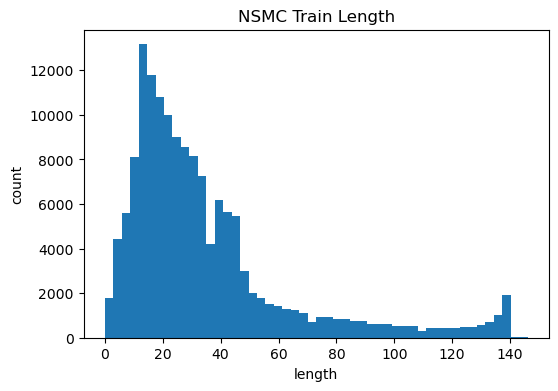

In [75]:
plt.figure(figsize=(6,4))
plt.hist(train_len, bins=50)
plt.title("NSMC Train Length")
plt.xlabel("length"); plt.ylabel("count"); plt.show()

MeCab 사용: 토큰 길이만 간단히 확인


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

[MeCab 토큰 길이] 평균 18.0, 중앙 14.0, p90 38.0, 최대 116


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


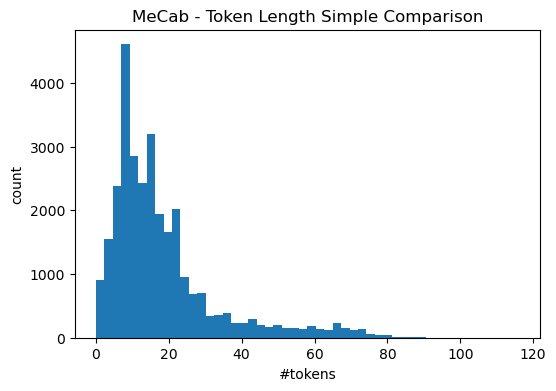

In [78]:
# 6) 형태소 간단 EDA (MeCab 있으면)
use_mecab = False
try:
    from konlpy.tag import Mecab
    mecab = Mecab(); use_mecab = True
except Exception:
    pass

if use_mecab:
    print("MeCab 사용: 토큰 길이만 간단히 확인")
    # 샘플 일부만(속도)
    sample_idx = np.random.choice(len(train_clean), size=min(30000, len(train_clean)), replace=False)
    tok_lens = []
    for i in sample_idx:
        tok_lens.append(len(mecab.morphs(train_clean[i])))
    arr = np.array(tok_lens)
    print(f"[MeCab 토큰 길이] 평균 {arr.mean():.1f}, 중앙 {np.median(arr):.1f}, p90 {np.percentile(arr,90):.1f}, 최대 {arr.max()}")
    plt.figure(figsize=(6,4))
    plt.hist(tok_lens, bins=50)
    plt.title("MeCab - Token Length Simple Comparison")
    plt.xlabel("#tokens"); plt.ylabel("count"); plt.show()

SentencePiece(sp) 감지됨 : SP 토큰 길이 분포도 같이 출력


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

[SP 토큰 길이] 평균 16.7, 중앙 12.0, p90 35.0, 최대 120


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


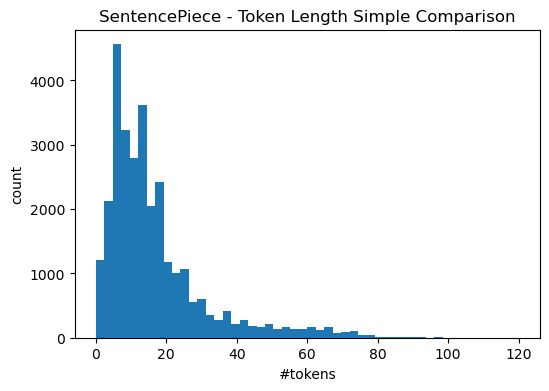

In [79]:
# 7) SentencePiece 길이 (이미 sp가 로드되어 있으면)
if "sp" in globals():
    print("SentencePiece(sp) 감지됨 : SP 토큰 길이 분포도 같이 출력")
    # 샘플 일부만(속도)
    sample_idx = np.random.choice(len(train_clean), size=min(30000, len(train_clean)), replace=False)
    sp_lens = []
    for i in sample_idx:
        sp_lens.append(len(sp.encode(train_clean[i], out_type=int)))
    arr = np.array(sp_lens)
    print(f"[SP 토큰 길이] 평균 {arr.mean():.1f}, 중앙 {np.median(arr):.1f}, p90 {np.percentile(arr,90):.1f}, 최대 {arr.max()}")
    plt.figure(figsize=(6,4))
    plt.hist(sp_lens, bins=50)
    plt.title("SentencePiece - Token Length Simple Comparison")
    plt.xlabel("#tokens"); plt.ylabel("count"); plt.show()

In [80]:
# 8) 라벨별 키워드 차이 (아주 간단)
# 자주 나오는 단어 상위만 대충 보기 (클린된 원문에서 띄어쓰기 split)
def top_words(texts, k=20):
    c = Counter()
    for s in texts:
        c.update(s.split())
    return c.most_common(k)

print("\n=== 자주 등장하는 단어(공백 기준, 대략적) ===")
print("train 상위 20:", top_words(train_clean, 20))


=== 자주 등장하는 단어(공백 기준, 대략적) ===
train 상위 20: [('영화', 11290), ('너무', 8264), ('정말', 7822), ('진짜', 5977), ('이', 5090), ('영화.', 3602), ('왜', 3293), ('이런', 3267), ('더', 3265), ('그냥', 3247), ('수', 2946), ('영화를', 2762), ('잘', 2659), ('다', 2628), ('보고', 2560), ('좀', 2456), ('영화는', 2428), ('그', 2426), ('영화가', 2424), ('본', 2298)]


In [81]:
# 9) 긍/부정 예시 몇 개 보기

import random
random.seed(42)
print("\n=== 긍정 예시 ===")
for s,l in random.sample(list(zip(train_clean, train_labels)), 5):
    if l==1: print(s); 
print("\n=== 부정 예시 ===")
for s,l in random.sample(list(zip(train_clean, train_labels)), 5):
    if l==0: print(s);


=== 긍정 예시 ===
해품달이좋으면 그냥 보면되지 악플달지마세요 평점낮아져요
너무 좋았다. 말이 필요 없음 . 계속 보고 싶다
인간승리 배재철! 역시 강한 의지와 용기, 그리고 사랑은 기적을 만듭니다

=== 부정 예시 ===
별안흥미진진 .
니미...영화보고 욕하긴첨일쎄...그리고 정말 평점 높게 주며 돈벌려는 알바들이 있긴 있나보네... 하긴 알바들이 무슨 죄겠냐... 쯧쯧...가엾다!
충격과 공포의 쓰레기영화다... 피안도라는 이름을 여기다가 붙이는거 자체가 아까움
